# Demographics Analysis on Banking Data
    
Our first will focus on identifying the characteristics of the demographic groups that lie within the data. We begin by importing the relevant packages.

In [2]:
import pandas as pd 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Declare variables for OneHotEncoder, StandardScaler, and PCA

In [3]:
ohe = OneHotEncoder(sparse=False)
scaler = StandardScaler()
pca = PCA()

Read the csv file and export to Pandas DataFrame. 

In [6]:
df = pd.read_csv('data/twm_customer.csv',sep=';')

Before diving into an inferential data analysis, we found it best to proceed with an exploratory study on the data. Since the data included a categorical feature for State of residence, a Chloropleth map seemed ideal to visualize the geographical distribution of the data. Additionally, because of the categorical nature of the state_codes, we planned on dropping them before the input of data to the ML Algorithm; so visualizing the geographical info before dropping it made sense. 

In [7]:
income_by_state = df[['state_code','income']].groupby('state_code').sum().sort_values(by='income',ascending=False)
income_by_state.reset_index(inplace=True)

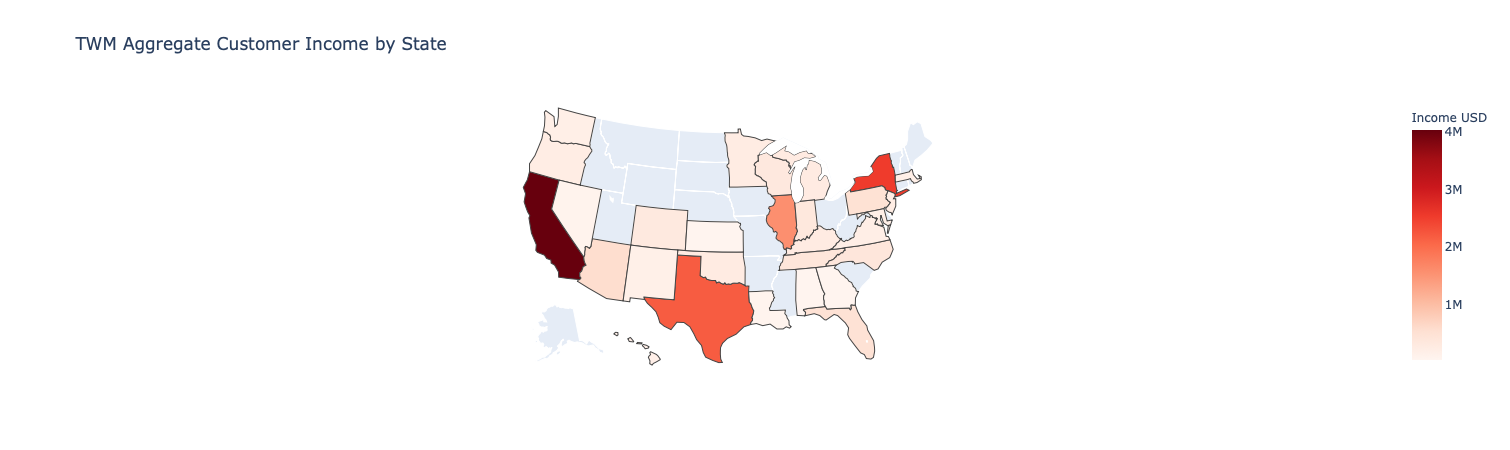

In [9]:
state_list = ['CA','NY','TX','IL','AZ','PA','FL','TN','MO''OH','NC','IN','WI','CO','MI','OK','KY','MN','NJ','OR','VA','MD','WA','MA','HI','NM','DC','NB','NV','LA','AL','GA','KS']
fig = go.Figure(data=go.Choropleth(
    locations=state_list, # Spatial coordinates
    z = income_by_state['income'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Income USD",
))

fig.update_layout(
    title_text = 'TWM Aggregate Customer Income by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

It becomes immediately apparent, that California, New York, and Texas lead in terms of aggregate income. 

## Data Preparation

The first decision taken was converting the remaining categorical variables to a numerical format so it could be used by our ML algorithms. 

In [232]:
state_labels = {st : i for i, st in enumerate(df.state_code.unique())} # dictionary comprehension for statecode re-labeling
df= df.replace({'gender': {'M ': 0, 'F ': 1},'state_code': state_labels }) # replace gender strings with binary values, replace state code with labels
marital_status_df = pd.DataFrame(ohe.fit_transform(df[['marital_status']]),  dtype='int64') # one hot encode values for marital status
df = df.drop(columns=['cust_id','first_name','last_name','name_prefix','street_nbr','street_name','postal_code','city_name','marital_status']) # drop unnecessary columns

The variables were then merged unto a single DataFrame

In [233]:
df = pd.concat([df, marital_status_df], axis=1)

A Scatter Matrix was conducted in order to search for any immediately visible patterns; the only interesting details visualized where
- an apparent gender disparity in terms of income, shown underneath as a burst of yellow on the top of the graph for gender (0 corresponds to Male), and 
- an apparent normal distribution shape regarding the scatter for income vs. age 

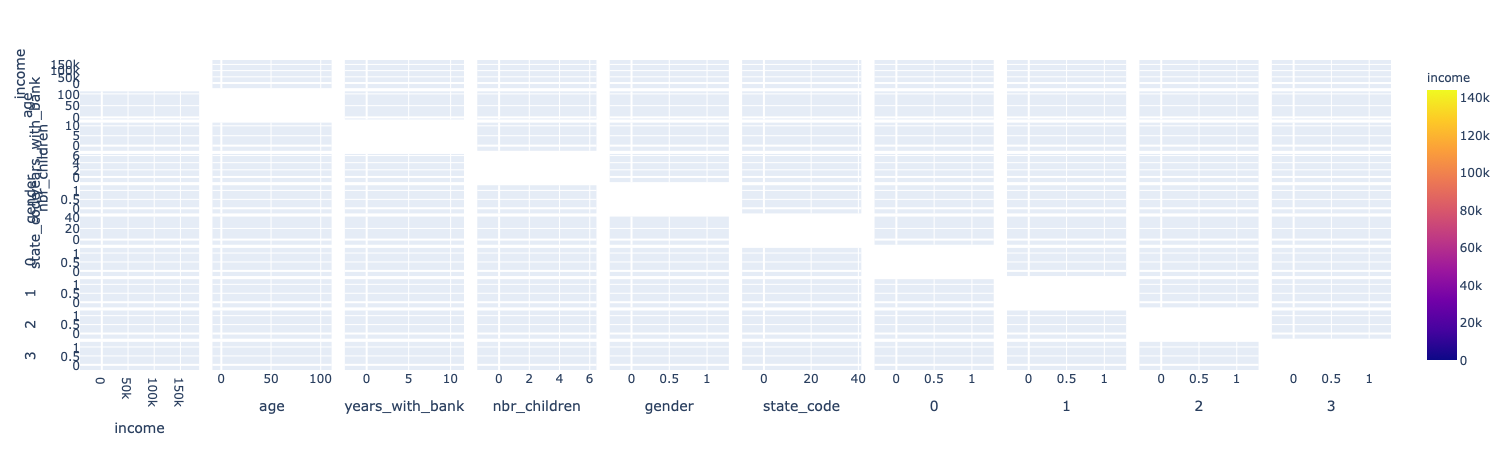

In [234]:
features = list(df.columns)

fig = px.scatter_matrix(
    df,
    dimensions=features,
    color="income"
)
fig.update_traces(diagonal_visible=False)
fig.show()

### Close-up of Gender Disparity

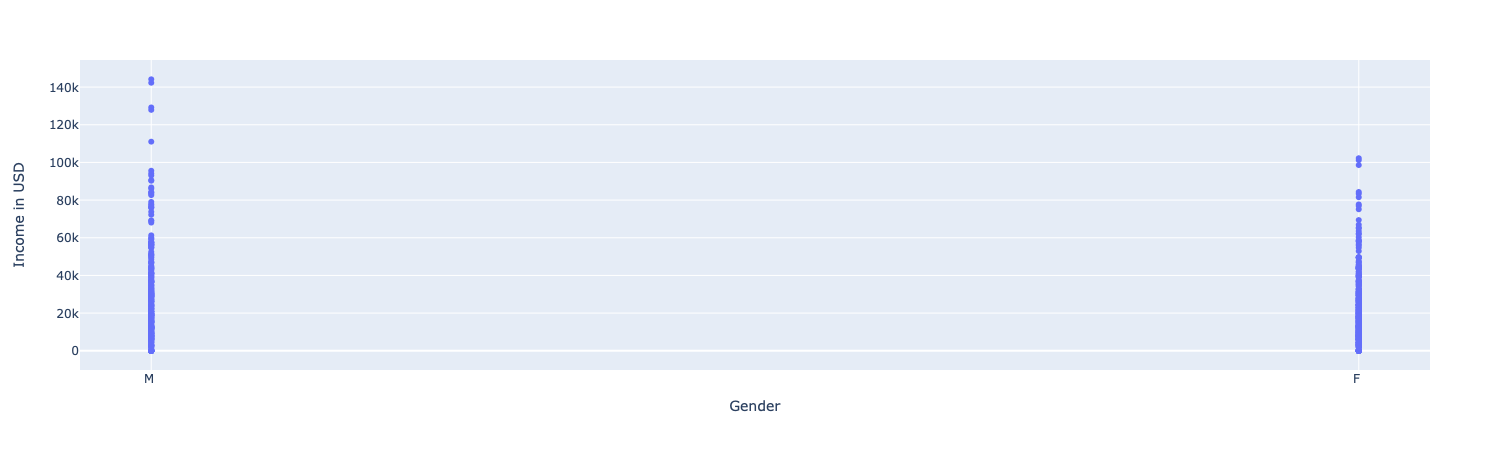

In [10]:
fig = px.scatter(df, x='gender',y='income',labels={'income':'Income in USD', 'gender': 'Gender'})
fig.show()

### The aforementioned "Normal Distribution"

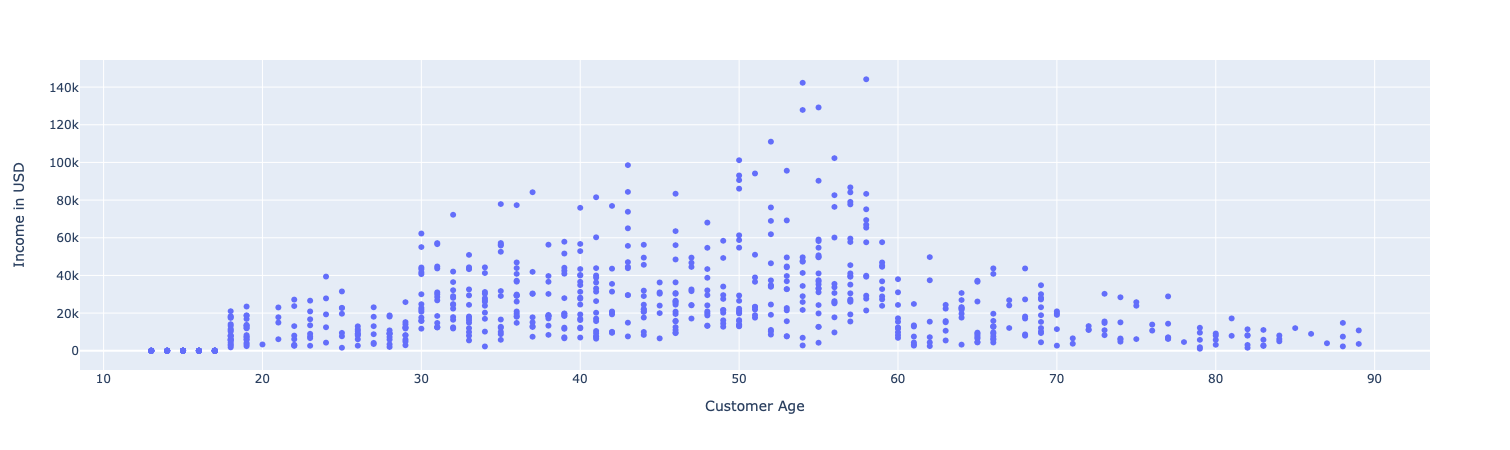

In [235]:
fig = px.scatter(df, x='age',y='income',labels={'income':'Income in USD', 'age': 'Customer Age'})
fig.show()

### Correlation Matrix

There are no apparent strong correlations between the variables of the data set. 

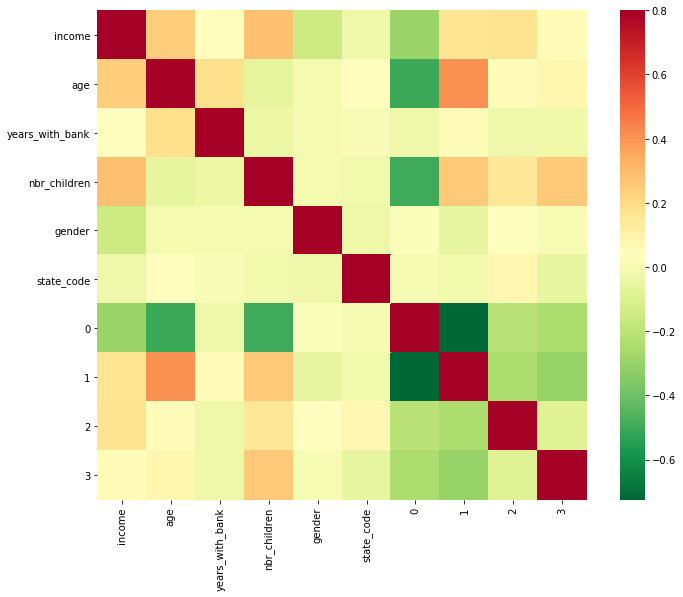

In [236]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="RdYlGn_r")

In [237]:
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df

income       age  years_with_bank  nbr_children    gender  state_code  \
0    0.154185  0.184312         0.408539      0.258591 -1.127172   -0.982716   
1   -0.726524  1.493070        -1.087435     -0.648298 -1.127172   -0.867020   
2   -0.188366 -0.234490         1.530520     -0.648298  0.887176   -0.867020   
3    1.123798  0.603115        -0.339448     -0.648298  0.887176   -0.867020   
4    0.983479  0.864867         1.904514      1.165479  0.887176   -0.751325   
..        ...       ...              ...           ...       ...         ...   
742 -0.357478 -0.339191         0.782533      0.258591  0.887176   -0.867020   
743  0.164864  0.707816         0.782533      0.258591 -1.127172   -0.751325   
744  1.738064  0.393714        -1.461429      1.165479 -1.127172    2.603849   
745 -0.343735 -0.286841         1.156526     -0.648298  0.887176    2.719545   
746 -0.218692 -1.281497        -0.339448     -0.648298  0.887176   -0.867020   

            0         1         2         3  
0   -0.765498  1.056479 -0.262049 -0.321555  
1   -0.765498  1.056479 -0.262049 -0.321555  
2    1.306339 -0.946541 -0.262049 -0.321555  
3    1.306339 -0.946541 -0.262049 -0.321555  
4   -0.765498 -0.946541 -0.262049  3.109892  
..        ...       ...       ...       ...  
742 -0.765498 -0.946541 -0.262049  3.109892  
743 -0.765498  1.056479 -0.262049 -0.321555  
744 -0.765498  1.056479 -0.262049 -0.321555  
745 -0.765498  1.056479 -0.262049 -0.321555  
746  1.306339 -0.946541 -0.262049 -0.321555  

[747 rows x 10 columns]

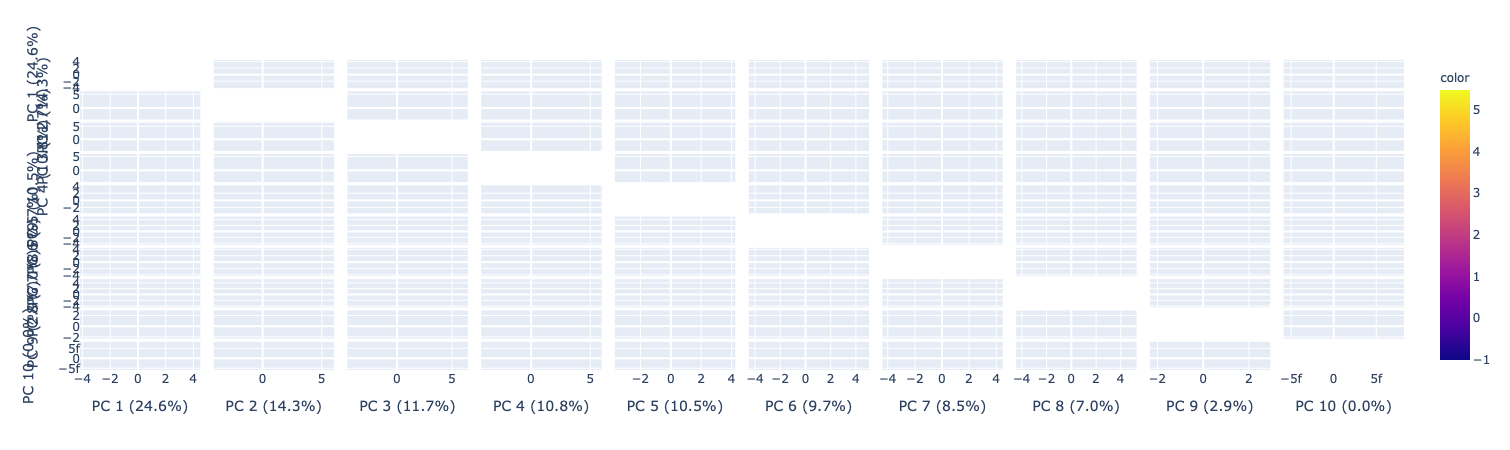

In [238]:
all_principal_components = pca.fit_transform(scaled_df)
labels = { str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ * 100)}
fig = px.scatter_matrix(
    all_principal_components, labels=labels, dimensions=range(10), color=scaled_df['income'])
fig.update_traces(diagonal_visible=False)
fig.show()

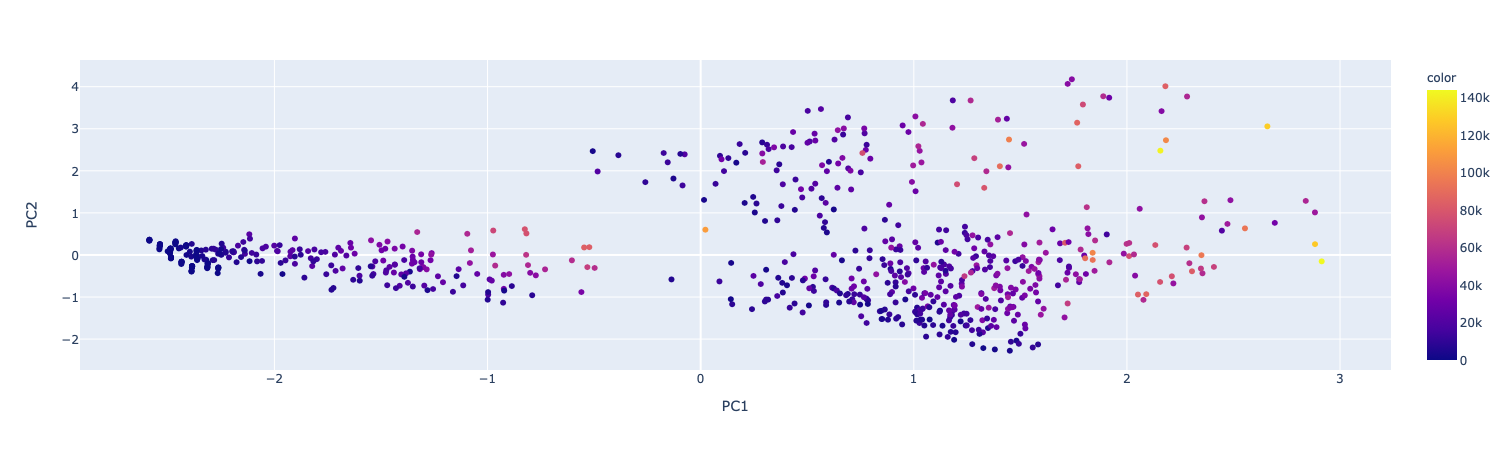

In [239]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_df)
labels = {
    'x':'PC1', 'y':'PC2'
}
fig = px.scatter(
    x = components[:, 0],
    y = components[:, 1],
    color=df['income'],
    labels=labels
)
# fig.update_traces(diagonal_visible=False)
fig.show()

In [240]:
# elbow rule
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

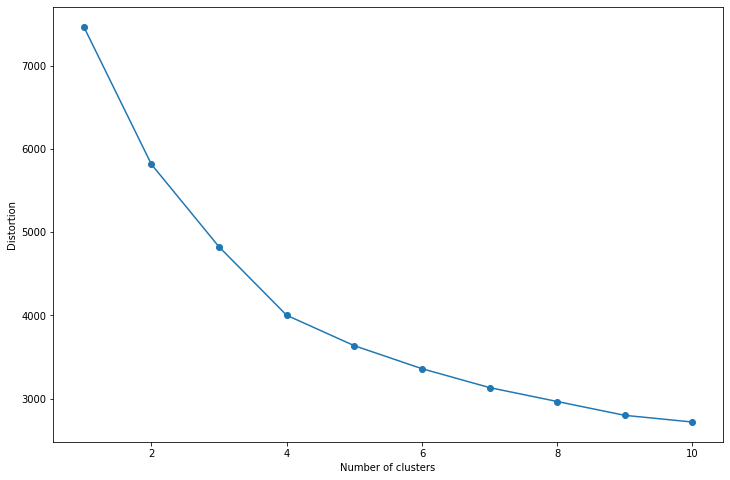

In [241]:
plot_distortion(scaled_df)

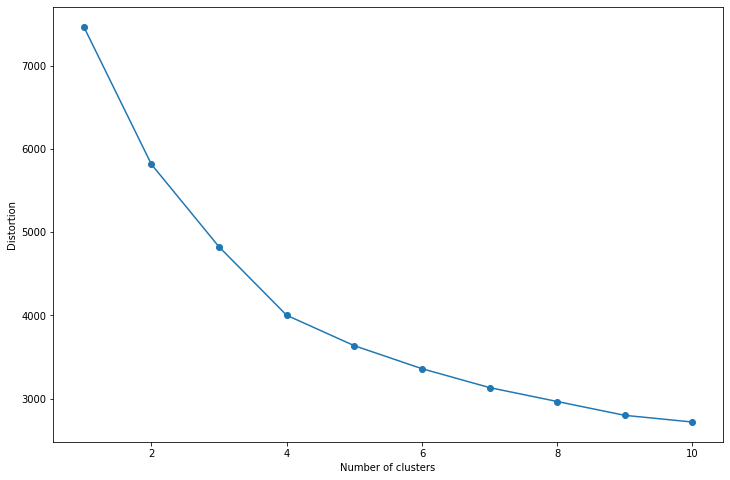

In [242]:
plot_distortion(all_principal_components)

In [243]:
km = KMeans(n_clusters=3 , n_init=10)
y_res = km.fit_predict(all_principal_components)

In [244]:
plt.rcParams["figure.figsize"] = (12,8)

In [245]:
 def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []
    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))
        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')
    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

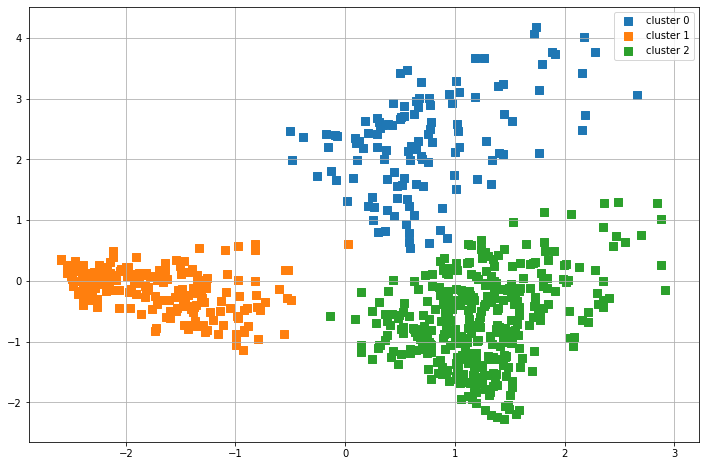

In [246]:
plot_clusters(all_principal_components,y_res)

In [247]:
feature_list = ['income','age','years_with_bank','nbr_children']

In [248]:
df['cluster_category'] = y_res

In [249]:
toplot_df = df
toplot_df['income'] = df['income'] / 1000

In [250]:
df_cluster1 = df[df['cluster_category'] == 0]
df_cluster2 = df[df['cluster_category'] == 1]
df_cluster3 = df[df['cluster_category'] == 2]

cluster_1_means = []
cluster_2_means = []
cluster_3_means = []

for feature in feature_list:
    cluster_1_means.append(df_cluster1[f'{feature}'].mean())
    cluster_2_means.append(df_cluster2[f'{feature}'].mean())
    cluster_3_means.append(df_cluster3[f'{feature}'].mean())
print('cluster1:',cluster_1_means)
print('cluster2:',cluster_2_means)
print('cluster3:',cluster_3_means)

cluster1: [31.207669491525408, 46.95762711864407, 3.6610169491525424, 1.4915254237288136]
cluster2: [14.167228260869564, 29.92753623188406, 3.8115942028985508, 0.0]
cluster3: [26.587439093484424, 50.79603399433428, 4.065155807365439, 1.0141643059490084]


In [255]:
def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

### Plotting Averages for Cluster 1

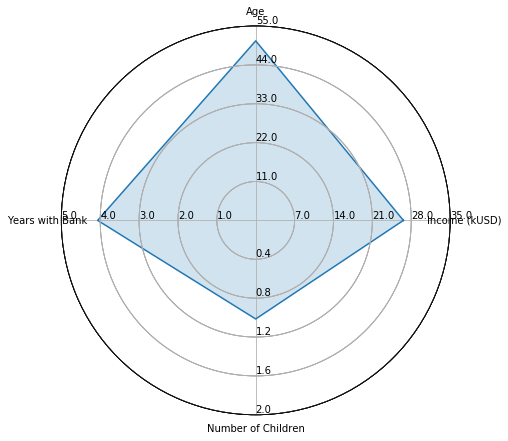

In [256]:
variables = ("Income (kUSD)", "Age", "Years with Bank", 
            "Number of Children")
data = (26.587439093484424, 50.79603399433428, 4.065155807365439, 1.0141643059490084)
ranges = [(0, 35), (0, 55), (0, 5),(0,2)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()    

### Plotting Averages for Cluster 2

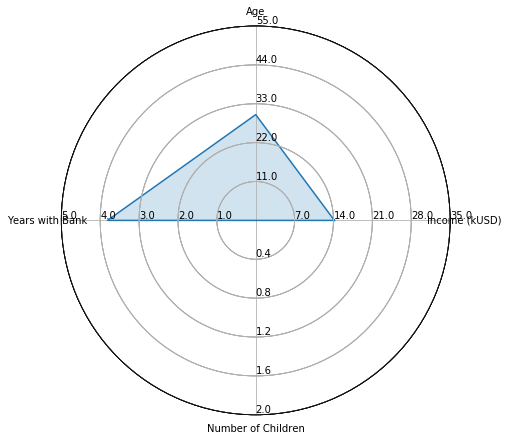

In [257]:
variables = ("Income (kUSD)", "Age", "Years with Bank", 
            "Number of Children")
data = (14.167228260869564, 29.92753623188406, 3.8115942028985508, 0.0)
ranges = [(0, 35), (0, 55), (0, 5),(0,2)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()    

### Plotting Averages for Cluster 3

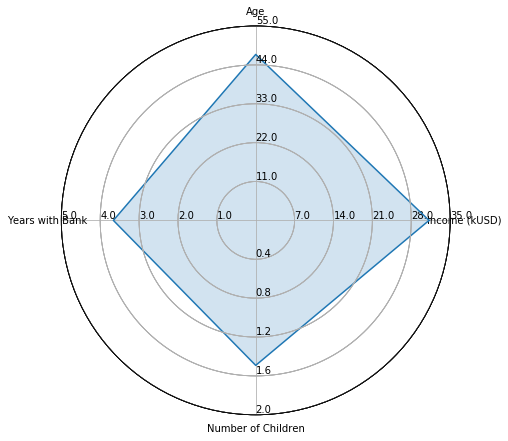

In [258]:
variables = ("Income (kUSD)", "Age", "Years with Bank", 
            "Number of Children")
data = (31.207669491525408, 46.95762711864407, 3.6610169491525424, 1.4915254237288136)
ranges = [(0, 35), (0, 55), (0, 5),(0,2)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()    

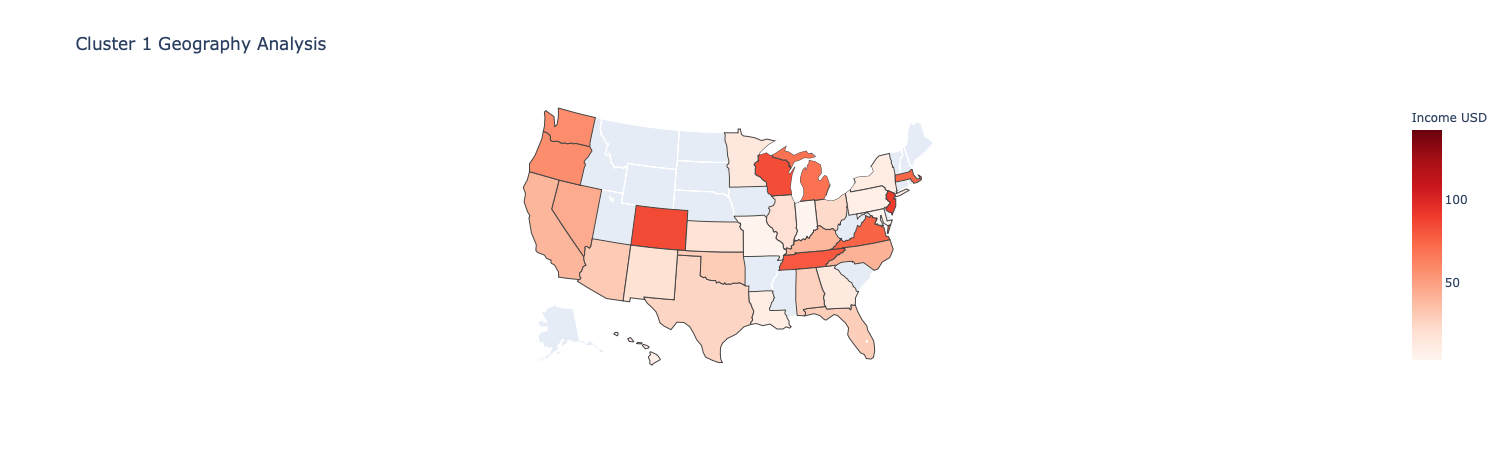

In [260]:
state_list = ['NV', 'CA', 'NY', 'IL', 'HI', 'DC', 'TX', 'PA', 'OR', 'OH', 'WA', 'NJ', 'IN', 'CO', 'WI', 'MI', 'NB', 'AZ', 'MN', 'TN', 'VA', 'FL', 'MD', 'MO', 'LA', 'KY', 'OK', 'MA',
'GA', 'KS', 'NC', 'NM', 'AL']
fig = go.Figure(data=go.Choropleth(
    locations=state_list, # Spatial coordinates
    z = df_cluster1['income'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Income USD",
))

fig.update_layout(
    title_text = 'Cluster 1 Geography Analysis',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

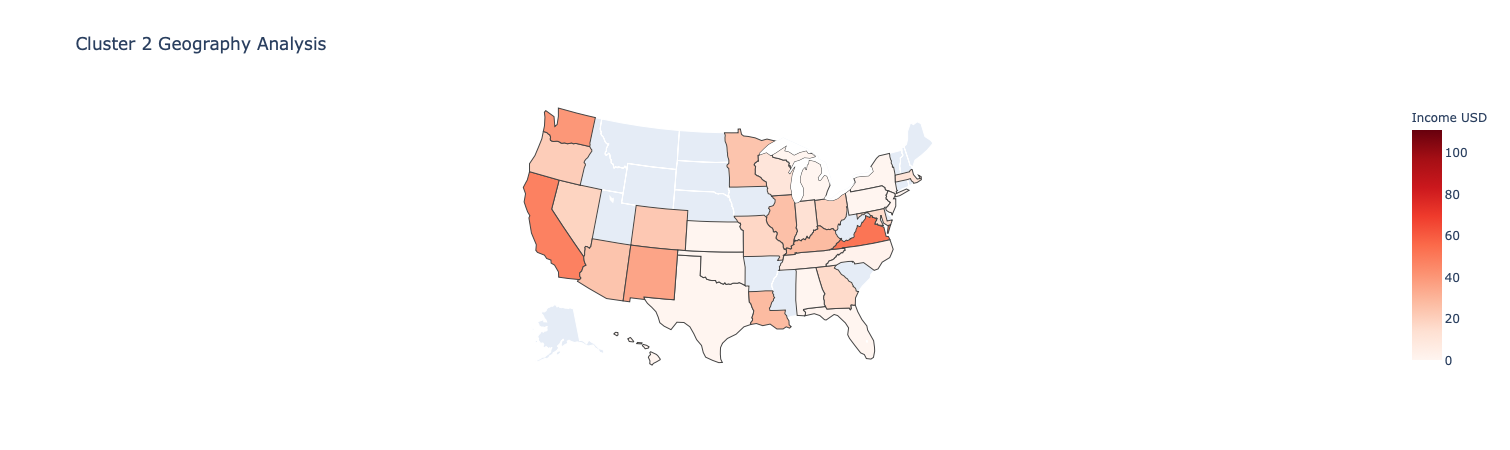

In [261]:
state_list = ['NV', 'CA', 'NY', 'IL', 'HI', 'DC', 'TX', 'PA', 'OR', 'OH', 'WA', 'NJ', 'IN', 'CO', 'WI', 'MI', 'NB', 'AZ', 'MN', 'TN', 'VA', 'FL', 'MD', 'MO', 'LA', 'KY', 'OK', 'MA',
'GA', 'KS', 'NC', 'NM', 'AL']
fig = go.Figure(data=go.Choropleth(
    locations=state_list, # Spatial coordinates
    z = df_cluster2['income'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Income USD",
))

fig.update_layout(
    title_text = 'Cluster 2 Geography Analysis',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

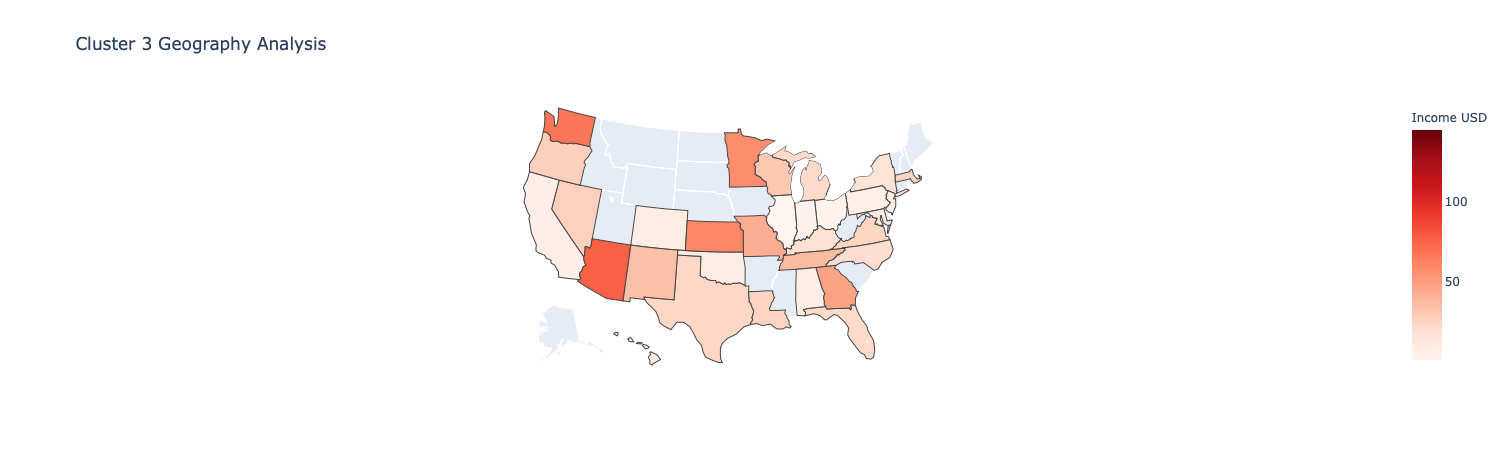

In [262]:
state_list = ['NV', 'CA', 'NY', 'IL', 'HI', 'DC', 'TX', 'PA', 'OR', 'OH', 'WA', 'NJ', 'IN', 'CO', 'WI', 'MI', 'NB', 'AZ', 'MN', 'TN', 'VA', 'FL', 'MD', 'MO', 'LA', 'KY', 'OK', 'MA',
'GA', 'KS', 'NC', 'NM', 'AL']
fig = go.Figure(data=go.Choropleth(
    locations=state_list, # Spatial coordinates
    z = df_cluster3['income'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Income USD",
))

fig.update_layout(
    title_text = 'Cluster 3 Geography Analysis',
    geo_scope='usa', # limit map scope to USA
)

fig.show()